### Board Game Ranking: Exploratory Data Analysis

#### Context: 

Board games have long been a part of human culture with the historical records dating back as early as 2000 B.C. In recent years, board games have experienced a resurgence in popularity. Tabletop gaming is now a burgeoning industry which had an estimated market of approximately 7.2 billion USD in 2017 and is expected to increase by 4.8 billion USD by 2023. The US card and board game market alone is predicted to increase to 5 billion USD by 2025. Understanding what makes a game popular is important for game developers to determine what kinds of games they should focus on producing.

I've scraped ranking data from https://www.boardgamegeek.com/browse/boardgame for 19,019 games which will be used in this analysis. This data is current as of 6/12/20.

In [1]:
# import packages and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.ticker import PercentFormatter
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
%matplotlib inline

bgg = pd.read_csv('bgg_clean_impute.csv', index_col=0)

# KNN was used to impute missing values. I'm rounding these columns to remove inconsistencies with age which 
# is recorded as a whole number as well as with player count which must be a whole number
bgg.age = bgg.age.round()
bgg.min_players = bgg.min_players.round()
bgg.max_players = bgg.max_players.round()

In [2]:
# descriptive statistics of the data set
bgg.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_rating,19019.0,6.386327,0.926332,1.050,5.800,6.420,7.000,9.690
geek_rating,19019.0,5.690209,0.370863,3.537,5.511,5.551,5.689,8.573
num_voters,19019.0,813.651349,3331.557546,30.000,55.000,120.000,379.500,94727.000
rank,19019.0,9511.235817,5491.270778,1.000,4755.500,9512.000,14266.500,19021.000
game_id,19019.0,99563.504969,93033.632027,1.000,9856.500,69105.000,180423.000,310100.000
age,19019.0,10.242337,2.710194,1.000,8.000,10.000,12.000,25.000
max_play_time,19019.0,99.528366,1033.539496,1.000,30.000,45.000,90.000,120000.000
max_players,19019.0,5.549293,9.087904,1.000,4.000,4.000,6.000,362.000
min_play_time,19019.0,68.703549,476.215933,1.000,20.000,30.000,60.000,60000.000
min_players,19019.0,2.036490,0.674595,1.000,2.000,2.000,2.000,10.000


In [3]:
bgg.head()

,avg_rating,geek_rating,num_voters,title,full_game_url,rank,game_id,category,mechanic,family,age,max_play_time,max_players,min_play_time,min_players,weight
0,8.83,8.573,35473,Gloomhaven,https://boardgamegeek.com/boardgame/174430/glo...,1,174430,"'Adventure', 'Exploration', 'Fantasy', 'Fighti...","'Action Retrieval', 'Campaign / Battle Card Dr...","'Components: Miniatures', 'Crowdfunding: Kicks...",12.0,120.0,4.0,60.0,1.0,3.832
1,8.62,8.472,37381,Pandemic Legacy: Season 1,https://boardgamegeek.com/boardgame/161936/pan...,2,161936,"'Environmental', 'Medical'","'Action Points', 'Cooperative Game', 'Hand Man...","'Game: Pandemic', 'Mechanic: Campaign Games', ...",13.0,60.0,4.0,60.0,2.0,2.830
2,8.64,8.279,13199,Brass: Birmingham,https://boardgamegeek.com/boardgame/224517/bra...,3,224517,"'Economic', 'Industry / Manufacturing', 'Trans...","'Connections', 'Hand Management', 'Income', 'L...","'Cities: Birmingham (England)', 'Country: Engl...",14.0,120.0,4.0,60.0,2.0,3.930
3,8.43,8.277,54788,Terraforming Mars,https://boardgamegeek.com/boardgame/167791/ter...,4,167791,"'Economic', 'Environmental', 'Industry / Manuf...","'Card Drafting', 'End Game Bonuses', 'Hand Man...","'Game: Terraforming Mars', 'Mechanic: Tableau ...",12.0,120.0,5.0,120.0,1.0,3.236
4,8.47,8.219,20264,Through the Ages: A New Story of Civilization,https://boardgamegeek.com/boardgame/182028/thr...,5,182028,"'Card Game', 'Civilization', 'Economic'","'Action Points', 'Auction/Bidding', 'Auction: ...","'Game: Through the Ages', 'Mechanic: Tableau B...",14.0,120.0,4.0,120.0,2.0,4.395


#### Description of attributes:

- avg_rating: aggregated ranking of user ratings (1-10)
- geek_rating: weighted avg rating used to determine a games rank (1-10) 
 - games must have a minimum of 30 user ratings to have a geek rating 
 - games without a geek rating are not included in this data set
- num_voters: number of users who have rated a game
- title: the name of the game
- full_game_url: game page
- rank: absolute ranking of a game based on geek rating
- game_id: unique identifyer
- category: a classification for the thematic type of board game
- mechanic: an element or type of gameplay
- family: an attempt to group a game into a broader set of descriptors
- age*: reccomened minimum age to play the game
- max_play_time*: the maximum time the game is estimated to complete
- max_players*: maximum number of players the game can support
- min_play_time*: the minimum time the game is estimated to complete
- min_players*: minimum number of players the game can support
- weight: an aggregated measure of complexity as reported by users (1-5)
 
*publisher provided values

### Numerical Attribute Exploration

I first want to investigate the distribution of ratings. Geek rating is what determines a games placement on the Geek Charts (the scraped pages) and this is based on an altered average rating. As found in the FAQ (https://boardgamegeek.com/wiki/page/BoardGameGeek_FAQ), Bayesian averaging is used to prevent games with few votes from skewing the data. The exact algorithm is unknown, but it is believed by the community that every game receives approximately 100 dummy votes with a 5.5 value.

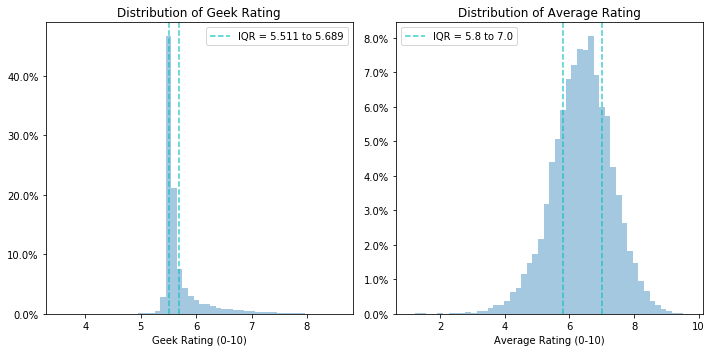

In [4]:
_ = plt.subplots(figsize=(10,5))
_ = plt.subplot(1,2,1)
_ = sns.distplot(bgg.geek_rating, hist_kws={'weights': (np.ones(len(bgg.geek_rating)) / len(bgg.geek_rating))}, kde=False)
_ = plt.axvline(x=bgg.geek_rating.quantile(0.25), label='IQR = 5.511 to 5.689', linestyle='--', color ='c', alpha=.75)
_ = plt.axvline(x=bgg.geek_rating.quantile(0.75), linestyle='--', color ='c', alpha=.75)
_ = plt.xlabel('Geek Rating (0-10)')
_ = plt.title('Distribution of Geek Rating')
_ = plt.legend()
_ = plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

_ = plt.subplot(1,2,2)
_ = sns.distplot(bgg.avg_rating, hist_kws={'weights': (np.ones(len(bgg.avg_rating)) / len(bgg.avg_rating))}, kde=False)
_ = plt.axvline(x=bgg.avg_rating.quantile(0.25), label='IQR = 5.8 to 7.0', linestyle='--', color ='c', alpha=.75)
_ = plt.axvline(x=bgg.avg_rating.quantile(0.75), linestyle='--', color ='c', alpha=.75)
_ = plt.xlabel('Average Rating (0-10)')
_ = plt.title('Distribution of Average Rating')
_ = plt.legend()
_ = plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.tight_layout()

The left chart shows the distribution of the geek rating. We can clearly see the Bayesian averaging in effect with the majority of games having a score between 5 and 6 as well as an incredible right skew.

In comparison, avg rating, representing raw user rating, in the right chart shows more distribution among values. Avg rating does not show the same skew and peaks around a rating of 7. This tells us that users tend to rate games positively (>5).

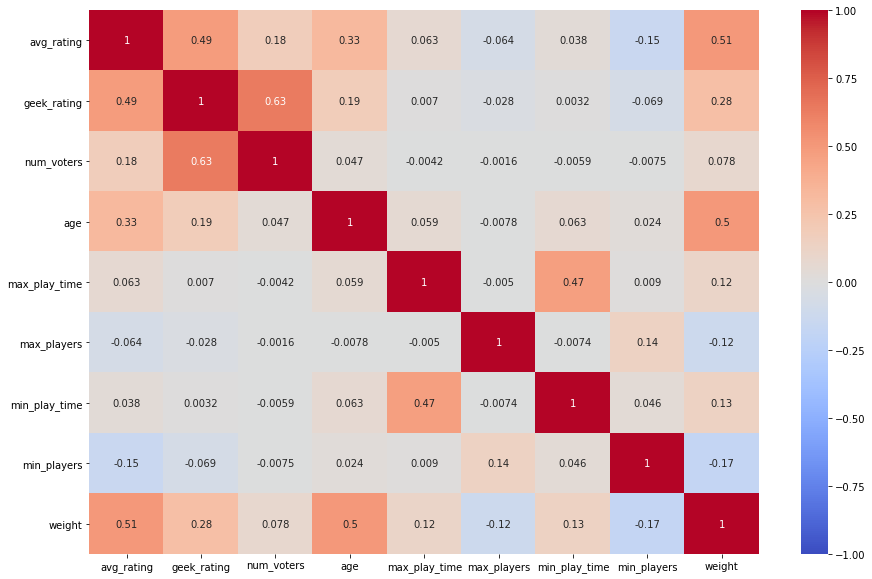

In [5]:
corr = bgg.drop(columns=['rank','game_id']).corr()
fig = plt.subplots(figsize=(15,10))
ax =  sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='coolwarm')

In examining the correlation between variables we can see that the number of votes shows the higest correlation with geek rating (as opposed to avg rating which was expected). In essence, the Bayesian averaging represents a hurdle to overcome and a game needs to be popular by avg rating before it can have a good geek rating.

So, we'll also want to look further at number of voters, age, and weight as they show correlation to both geek rating and avg rating.

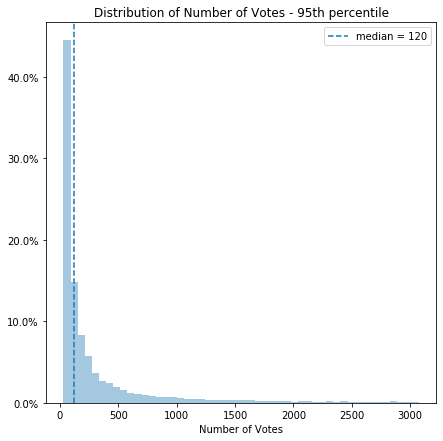

In [6]:
# Num_voters includes significant outliers. Incredibly popular games receive a high 
# volume of votes while the average is much lower so I've only plotted the 95th percentile
bgg_votes = bgg[['num_voters']]
p95 = bgg_votes.quantile(0.95)
bgg_votes95 = bgg_votes[(bgg_votes < p95).any(axis=1)]

_ = plt.figure(figsize=(7,7))
_ = sns.distplot(bgg_votes95, kde=False, hist_kws={'weights' : (np.ones(len(bgg_votes95)) / len(bgg_votes95))})
_ = plt.axvline(x=bgg.num_voters.median(), label='median = 120', linestyle='--')
_ = plt.xlabel('Number of Votes')
_ = plt.title('Distribution of Number of Votes - 95th percentile')
_ = plt.legend()
_ = plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

While the max number of votes for a game is 94,727, the median is 120. This explains why the geek rating rarely deviates from the 5.5 range.

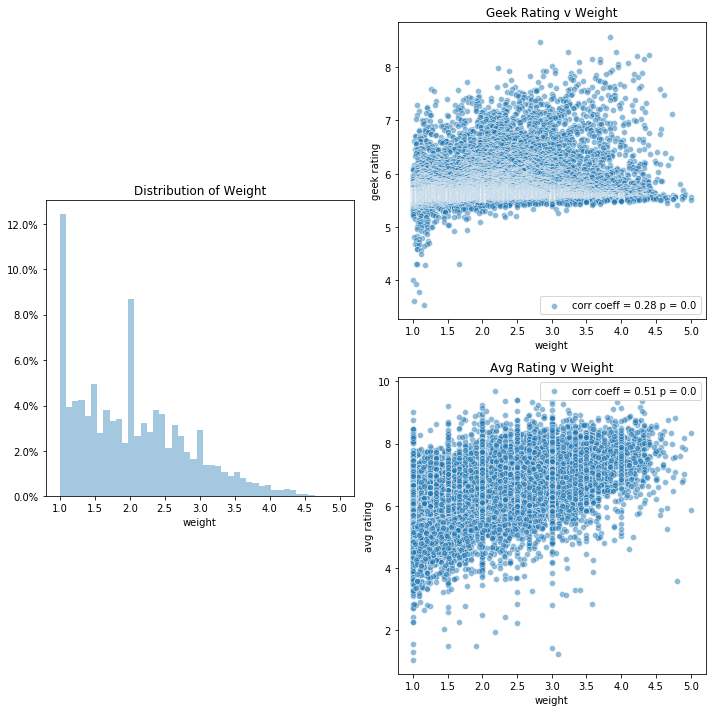

In [7]:
geek_v_weight_coef, geek_v_weight_p = stats.pearsonr(bgg.weight, bgg.geek_rating)
avg_v_weight_coef, avg_v_weight_p = stats.pearsonr(bgg.weight, bgg.avg_rating)


fig = plt.figure(tight_layout=True, figsize=(10,10))
gs = gridspec.GridSpec(8, 2)

ax = fig.add_subplot(gs[2:6, 0])
_ = sns.distplot(bgg.weight, kde=False, hist_kws={'weights' : (np.ones(len(bgg.weight)) / len(bgg.weight))})
_ = plt.title('Distribution of Weight')
_ = plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#_ = plt.savefig('images/Weight_Distribution.png')

ax = fig.add_subplot(gs[0:4, 1])
_ = sns.scatterplot(x='weight', y='geek_rating', data=bgg, alpha=.5, label=str('corr coeff = ' + str(round(geek_v_weight_coef,2)) + ' p = ' + str(geek_v_weight_p)))
_ = plt.ylabel('geek rating')
_ = plt.title('Geek Rating v Weight')
#_ = plt.savefig('images/Geek_Rating_v_Weight.png')

ax = fig.add_subplot(gs[4:8, 1])
_ = sns.scatterplot(x='weight', y='avg_rating', data=bgg, alpha=.5, label=str('corr coeff = ' + str(round(avg_v_weight_coef,2)) + ' p = ' + str(avg_v_weight_p)))
_ = plt.ylabel('avg rating')
_ = plt.title('Avg Rating v Weight')
#_ = plt.savefig('images/Avg_Rating_v_Weight.png')

Weight is a user generated number between 1 and 5 representing the complexity of a game. As this is an average, it is biased towards whole and half numbers (e.g. 2.0 or 3.5) due to the volume of games with minimal number of user values recorded. The scatter plots help illuminate how the Bayesian averaging affects correlation with geek rating.

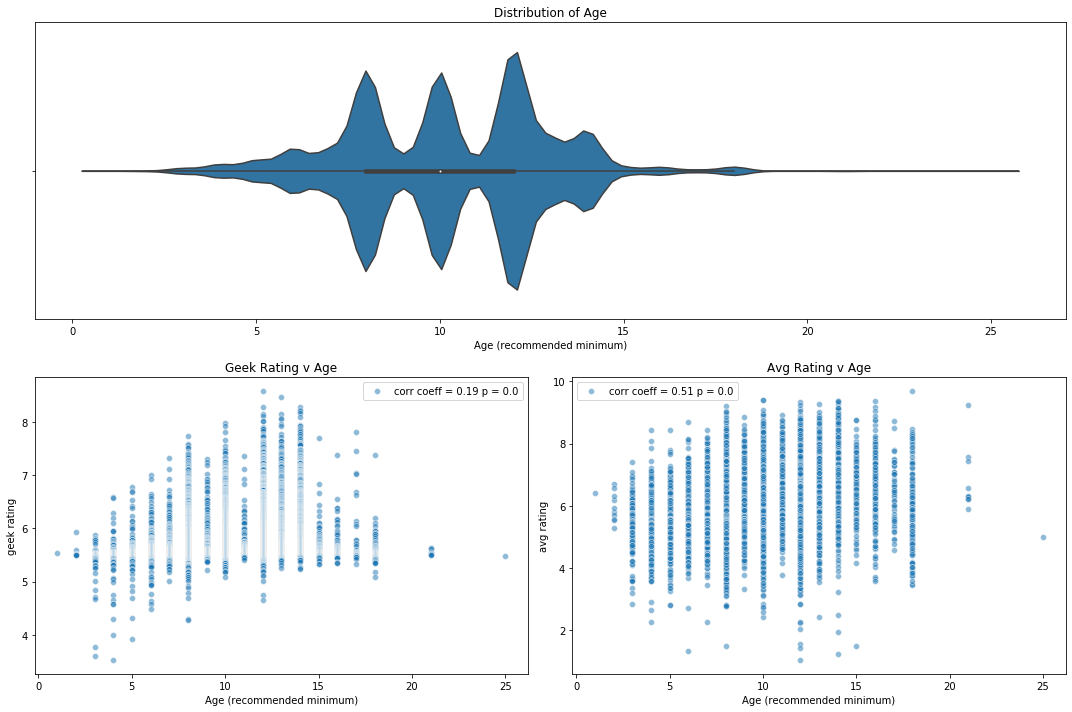

In [8]:
geek_v_age_coef, geek_v_age_p = stats.pearsonr(bgg.age, bgg.geek_rating)
avg_v_age_coef, avg_v_age_p = stats.pearsonr(bgg.age, bgg.avg_rating)

fig = plt.figure(tight_layout=True, figsize=(15,10))
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0,:])
_ = sns.violinplot('age', data=bgg)
_ = plt.title('Distribution of Age')
_ = plt.xlabel("Age (recommended minimum)")
#_ = plt.savefig('images/Age_Distribution.png')

ax = fig.add_subplot(gs[1,0])
_ = sns.scatterplot(x='age', y='geek_rating', data=bgg, alpha=.5, label=str('corr coeff = ' + str(round(geek_v_age_coef,2)) + ' p = ' + str(round(geek_v_age_p,2))))
_ = plt.ylabel('geek rating')
_ = plt.title('Geek Rating v Age')
_ = plt.xlabel("Age (recommended minimum)")
#_ = plt.savefig('images/Geek_Rating_v_Age.png')


ax = fig.add_subplot(gs[1,1])
_ = sns.scatterplot(x='age', y='avg_rating', data=bgg, alpha=.5, label=str('corr coeff = ' + str(round(avg_v_weight_coef,2)) + ' p = ' + str(avg_v_weight_p)))
_ = plt.ylabel('avg rating')
_ = plt.title('Avg Rating v Age')
_ = plt.xlabel("Age (recommended minimum)")
#_ = plt.savefig('images/Avg_Rating_v_Weight.png')

Mean age is 10, but there are also distribution spikes around 8 and 12-13. We will have to keep an eye on colinearity due to the correlations between age and weight as both of those showing correlation with geek rating.

## Label Analysis

The scraped data also includes classifications for each game: Category, Mechanic, and Family. As outlined above:

 - Category is a classification for the thematic type of board game e.g. fantasy or children's game. (There are 83 categories.)
 - Mechanic is an element or type of gameplay. Examples include dice rolling, role play, and trading. (There are 186 mechanics.)
 - Family attempts to group a game into a broader set of descriptors. There is a large variety in family including items such as Ancient: Greece, Crowdfunding: Kickstarter, and Video Game Theme: Pokémon. (There are 2,748 families.)


Each game can be assigned multiple categories, mechanics and family. The lists of category, mechanic and family can be found in these links:
 - https://boardgamegeek.com/browse/boardgamecategory
 - https://boardgamegeek.com/browse/boardgamemechanic
 - https://boardgamegeek.com/browse/boardgamefamily


In [9]:
# creating new dataframes for each label type.
cat = bgg[['geek_rating']]
csplit = bgg.category.str.split(', ', expand=True)
cat = cat.merge(csplit, left_index=True, right_index=True)

mech = bgg[['geek_rating']]
msplit = bgg.mechanic.str.split(', ', expand=True)
mech = mech.merge(msplit, left_index=True, right_index=True)

fam = bgg[['geek_rating']]
fsplit = bgg.family.str.split(', ', expand=True)
fam = fam.merge(fsplit, left_index=True, right_index=True)

# melting dataframes so that its tidy
cat = cat.melt(id_vars=['geek_rating'], value_name='category').drop(columns='variable').dropna()
mech = mech.melt(id_vars=['geek_rating'], value_name='mechanic').drop(columns='variable').dropna()
fam = fam.melt(id_vars=['geek_rating'], value_name='family').drop(columns='variable').dropna()

# grouping by classification.
cat_group = cat.groupby(cat.category).geek_rating.agg(['count','mean'])
fam_group = fam.groupby(fam.family).geek_rating.agg(['count','mean'])
mech_group = mech.groupby(mech.mechanic).geek_rating.agg(['count','mean'])

In [10]:
cat_group.sort_values(by='mean').head()

,count,mean
category,,
'Trivia',515,5.528363
"""Children's Game""",1427,5.529584
'Memory',477,5.552136
'Electronic',188,5.566516
'Math',129,5.568543


These are the the 5 worst rated categories. In particular, the Children's Games category being a low rating category aligns with the correlation between rating and age.

In [11]:
cat_group.sort_values(by='mean').tail()

,count,mean
category,,
'Farming',213,5.931338
'Renaissance',238,5.953256
'Industry / Manufacturing',260,5.978542
'City Building',473,5.993662
'Civilization',310,6.047019


And the 5 top rated categories.

Due to the sheer volume of labels in mechanic and family I only want to examine those that are well represented. That is, if only a handful of games in the data set have a particular label, then that label is not representative and can't tell us much on its own about the data set and rating trends of that label. For my purposes here I'll set it to count > 5.

In [12]:
mech_group[mech_group['count'] > 5].sort_values(by='mean').head()

,count,mean
mechanic,,
'Roll / Spin and Move',1250,5.522811
'Singing',47,5.542766
'Zone of Control',115,5.597096
'Pattern Recognition',488,5.598094
'Rock-Paper-Scissors',151,5.605026


The worst 5 rated mechanics. I think its fair to say that these are not mechanics you'd think of as your typical board game.

In [13]:
mech_group[mech_group['count'] > 5].sort_values(by='mean').tail()

,count,mean
mechanic,,
'Force Commitment',7,7.102714
'Action Drafting',18,7.142444
'Turn Order: Role Order',6,7.148500
'Automatic Resource Growth',10,7.308900
'Turn Order: Pass Order',7,7.632571


The top 5 rated mechanics. These appear to be indicative of a more complex rule set.

In [14]:
fam_group[fam_group['count'] > 5].sort_values(by='mean').head()

,count,mean
family,,
'TV Series: Dora the Explorer',8,4.533125
'Toys: Lalaloopsy',6,4.831500
'Characters: Hello Kitty',11,4.892636
'Comic Strips: King Features Syndicate',8,4.920500
'Characters: Smurfs',8,4.924375


The worst 5 rated families. Again we see games geared towards children.

In [15]:
fam_group[fam_group['count'] > 5].sort_values(by='mean').tail()

,count,mean
family,,
'Series: Alea Big Box',17,6.912235
'Game: Pandemic',11,6.981545
'Living Card Game',11,7.029636
'Series: Arkham Horror (Fantasy Flight Games)',8,7.129500
'Series: Harvest (Uwe Rosenberg)',12,7.380000


And finally, for the top rated family labels we see various franchises. 